# Part 2: Exploratory Data Analysis

## Any transformations needed?
Yes. My initial transformation will be to encode the diagnosis column, such that Malignant = 1 and Benign = 0. Since there are only two unique values here, this will be easy to encode without having to use the OrdinalEncoder library.

In order to use the K nearest neighbors or K means clustering, I will need to normalize the features as they can have large differences. I will also need to omit these columns from the scaler, since they are irrelevant to the measurements of cells.

I intend to use the Scaler library on the data except on ‘id’ and ‘diagnosis’.

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

stder = StandardScaler()
df = pd.read_csv("/Users/daniel/Desktop/Cancer_Data.csv")
# https://www.kaggle.com/datasets/erdemtaha/cancer-data

df_scaled = df.copy(deep=True) # deep copy the df, just in case we want to see the original data
df_scaled = df_scaled.drop(columns='id') # drop this column because it is a 1-1 mapping to each row
df_scaled.iloc[:,1:] = stder.fit_transform(df_scaled.iloc[:,1:]) # scale columns 2 and forward. omit the diagnosis b/c that is the classifier

df_scaled['diagnosis'] = df_scaled['diagnosis'].replace('B',0).replace('M', 1) # encode the 'diagnosis' column



/var/folders/p1/tr2gvl0j7zq97gg5g84y22ch0000gn/T/ipykernel_52835/2376832012.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_scaled['diagnosis'] = df_scaled['diagnosis'].replace('B',0).replace('M', 1) # encode the 'diagnosis' column


## Plan for separating
First, I will separate my data for the columns with the measurements and a classification column. ‘x’ for the measurements, and ‘y’ for the classification.

In [5]:
x = df_scaled.iloc[:,1:].values
y = df_scaled['diagnosis'].values


I then will use stratified K folds. Given my dataset has 569 rows, I will be more conservative with the amount of data separated for the test and validation sets. Instead of the typical 80/20 split, I will do an 85/15 split.
    ● Training Set: 85% (484 rows)
    ● Test Set: 15% (85 rows)

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Split the data into training and a test set
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=85,
                                                    stratify=y,
                                                    random_state=42)

I will then use 20 folds using the stratified K folds to further split my training data into smaller training sets and validation sets to use for hyperparameter tuning later on.

In [7]:
# Use k folds to split the training set into smaller training sets and validation sets. 10 folds
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):

    # training sets
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]

    # validation sets
    x_val_fold =  x_train[val_index]
    y_val_fold = y_train[val_index]

    # print(len(train_index))
    # print(len(val_index))

## Visualization of Data:
First, I decided to visualize the mean, standard error, and worst columns separately. We can generally see the strongest correlations (negative included) are between the circle’s sizing (radius, perimeter, area) vs the circle’s shape (fractal_dimension, symmetry, concave points_mean). These relationships may offer insight into which columns can train the model better.

<Axes: >

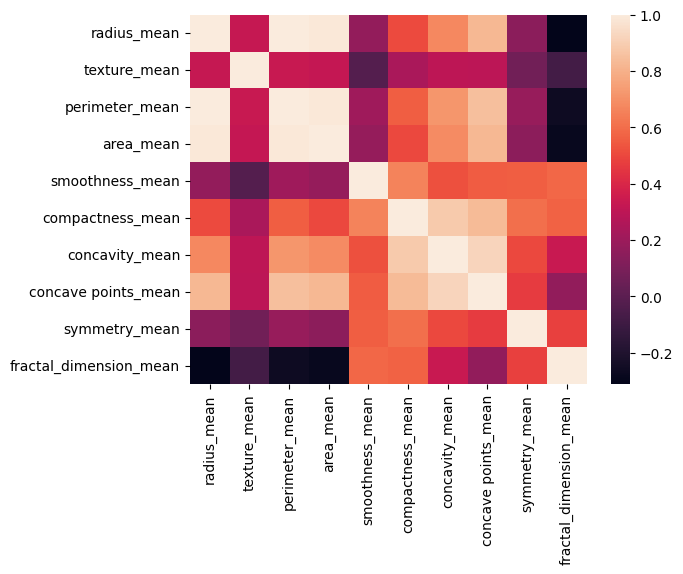

In [8]:
import seaborn as sns

mean_columns = ['radius_mean', 'texture_mean', 'perimeter_mean',
    'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

# mean columns
# represent feature correlation matrix using a heatmap
corr_mean = df[mean_columns].corr()

# plot the heatmap
sns.heatmap(corr_mean, 
        xticklabels=corr_mean.columns,
        yticklabels=corr_mean.columns)

<Axes: >

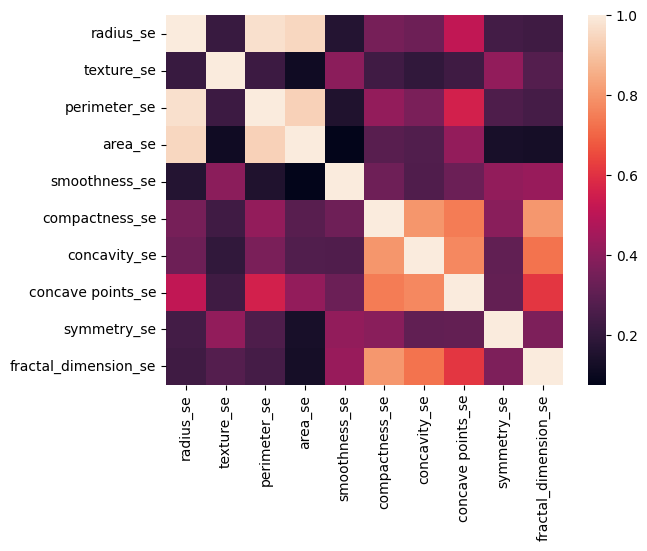

In [9]:
se_columns = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
    'fractal_dimension_se']

# se columns
# represent feature correlation matrix using a heatmap
corr_se = df[se_columns].corr()

# plot the heatmap
sns.heatmap(corr_se, 
        xticklabels=corr_se.columns,
        yticklabels=corr_se.columns)

<Axes: >

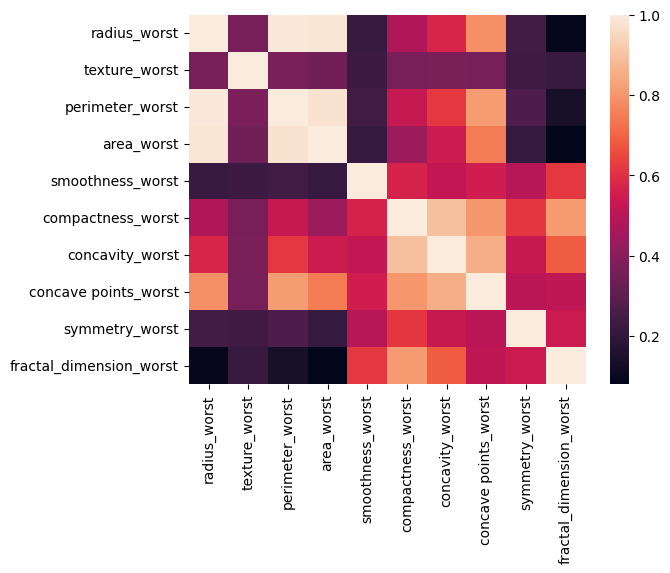

In [10]:
worst_columns = ['radius_worst', 'texture_worst',
    'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst',
    'symmetry_worst', 'fractal_dimension_worst']

# se columns
# represent feature correlation matrix using a heatmap
corr_worst = df[worst_columns].corr()

# plot the heatmap
sns.heatmap(corr_worst, 
        xticklabels=corr_worst.columns,
        yticklabels=corr_worst.columns)

Seeing these relationships, I took a mixture of columns related to the size vs shape of the cell’s circle and created a heatmap out of those. Below, you can generally see the same correlations persist even across the (‘mean’ vs ‘standard error’) or’ (‘standard error’ vs ‘worst columns’).

<Axes: >

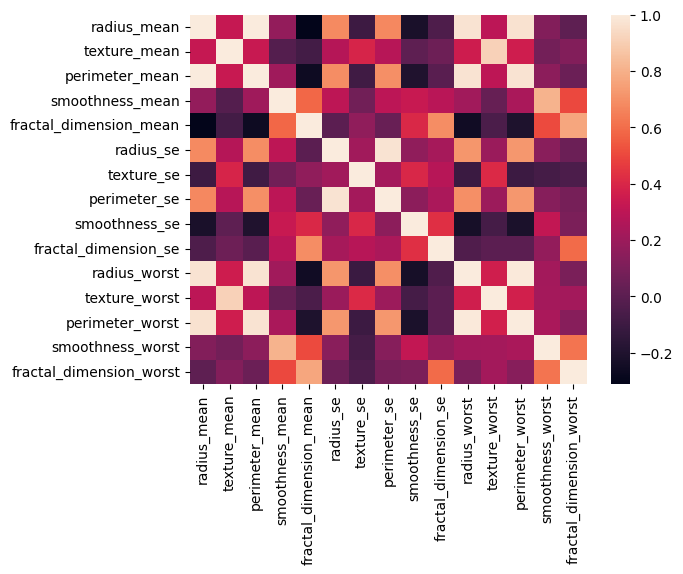

In [11]:
columns_mixed = [
    'radius_mean','texture_mean','perimeter_mean','smoothness_mean','fractal_dimension_mean',
    'radius_se','texture_se','perimeter_se','smoothness_se','fractal_dimension_se',
    'radius_worst','texture_worst','perimeter_worst','smoothness_worst','fractal_dimension_worst']

# represent feature correlation matrix using a heatmap
corr_mixed = df[columns_mixed].corr()

# plot the heatmap
sns.heatmap(corr_mixed, 
        xticklabels=corr_mixed.columns,
        yticklabels=corr_mixed.columns)

To provide emphasis on the correlations, I also created some scatter plots to better visualize the data. While there is a clear relationship between variables related to the size of the circle, we can also see clustering in the other plots. For example, we can see a cluster in the (‘perimeter_mean’ vs ‘symmetry_mean’). Because malignant tumors are abnormal in themselves, my intuition tells me that any points that fall outside of the cluster are indicative of a malignant diagnosis.

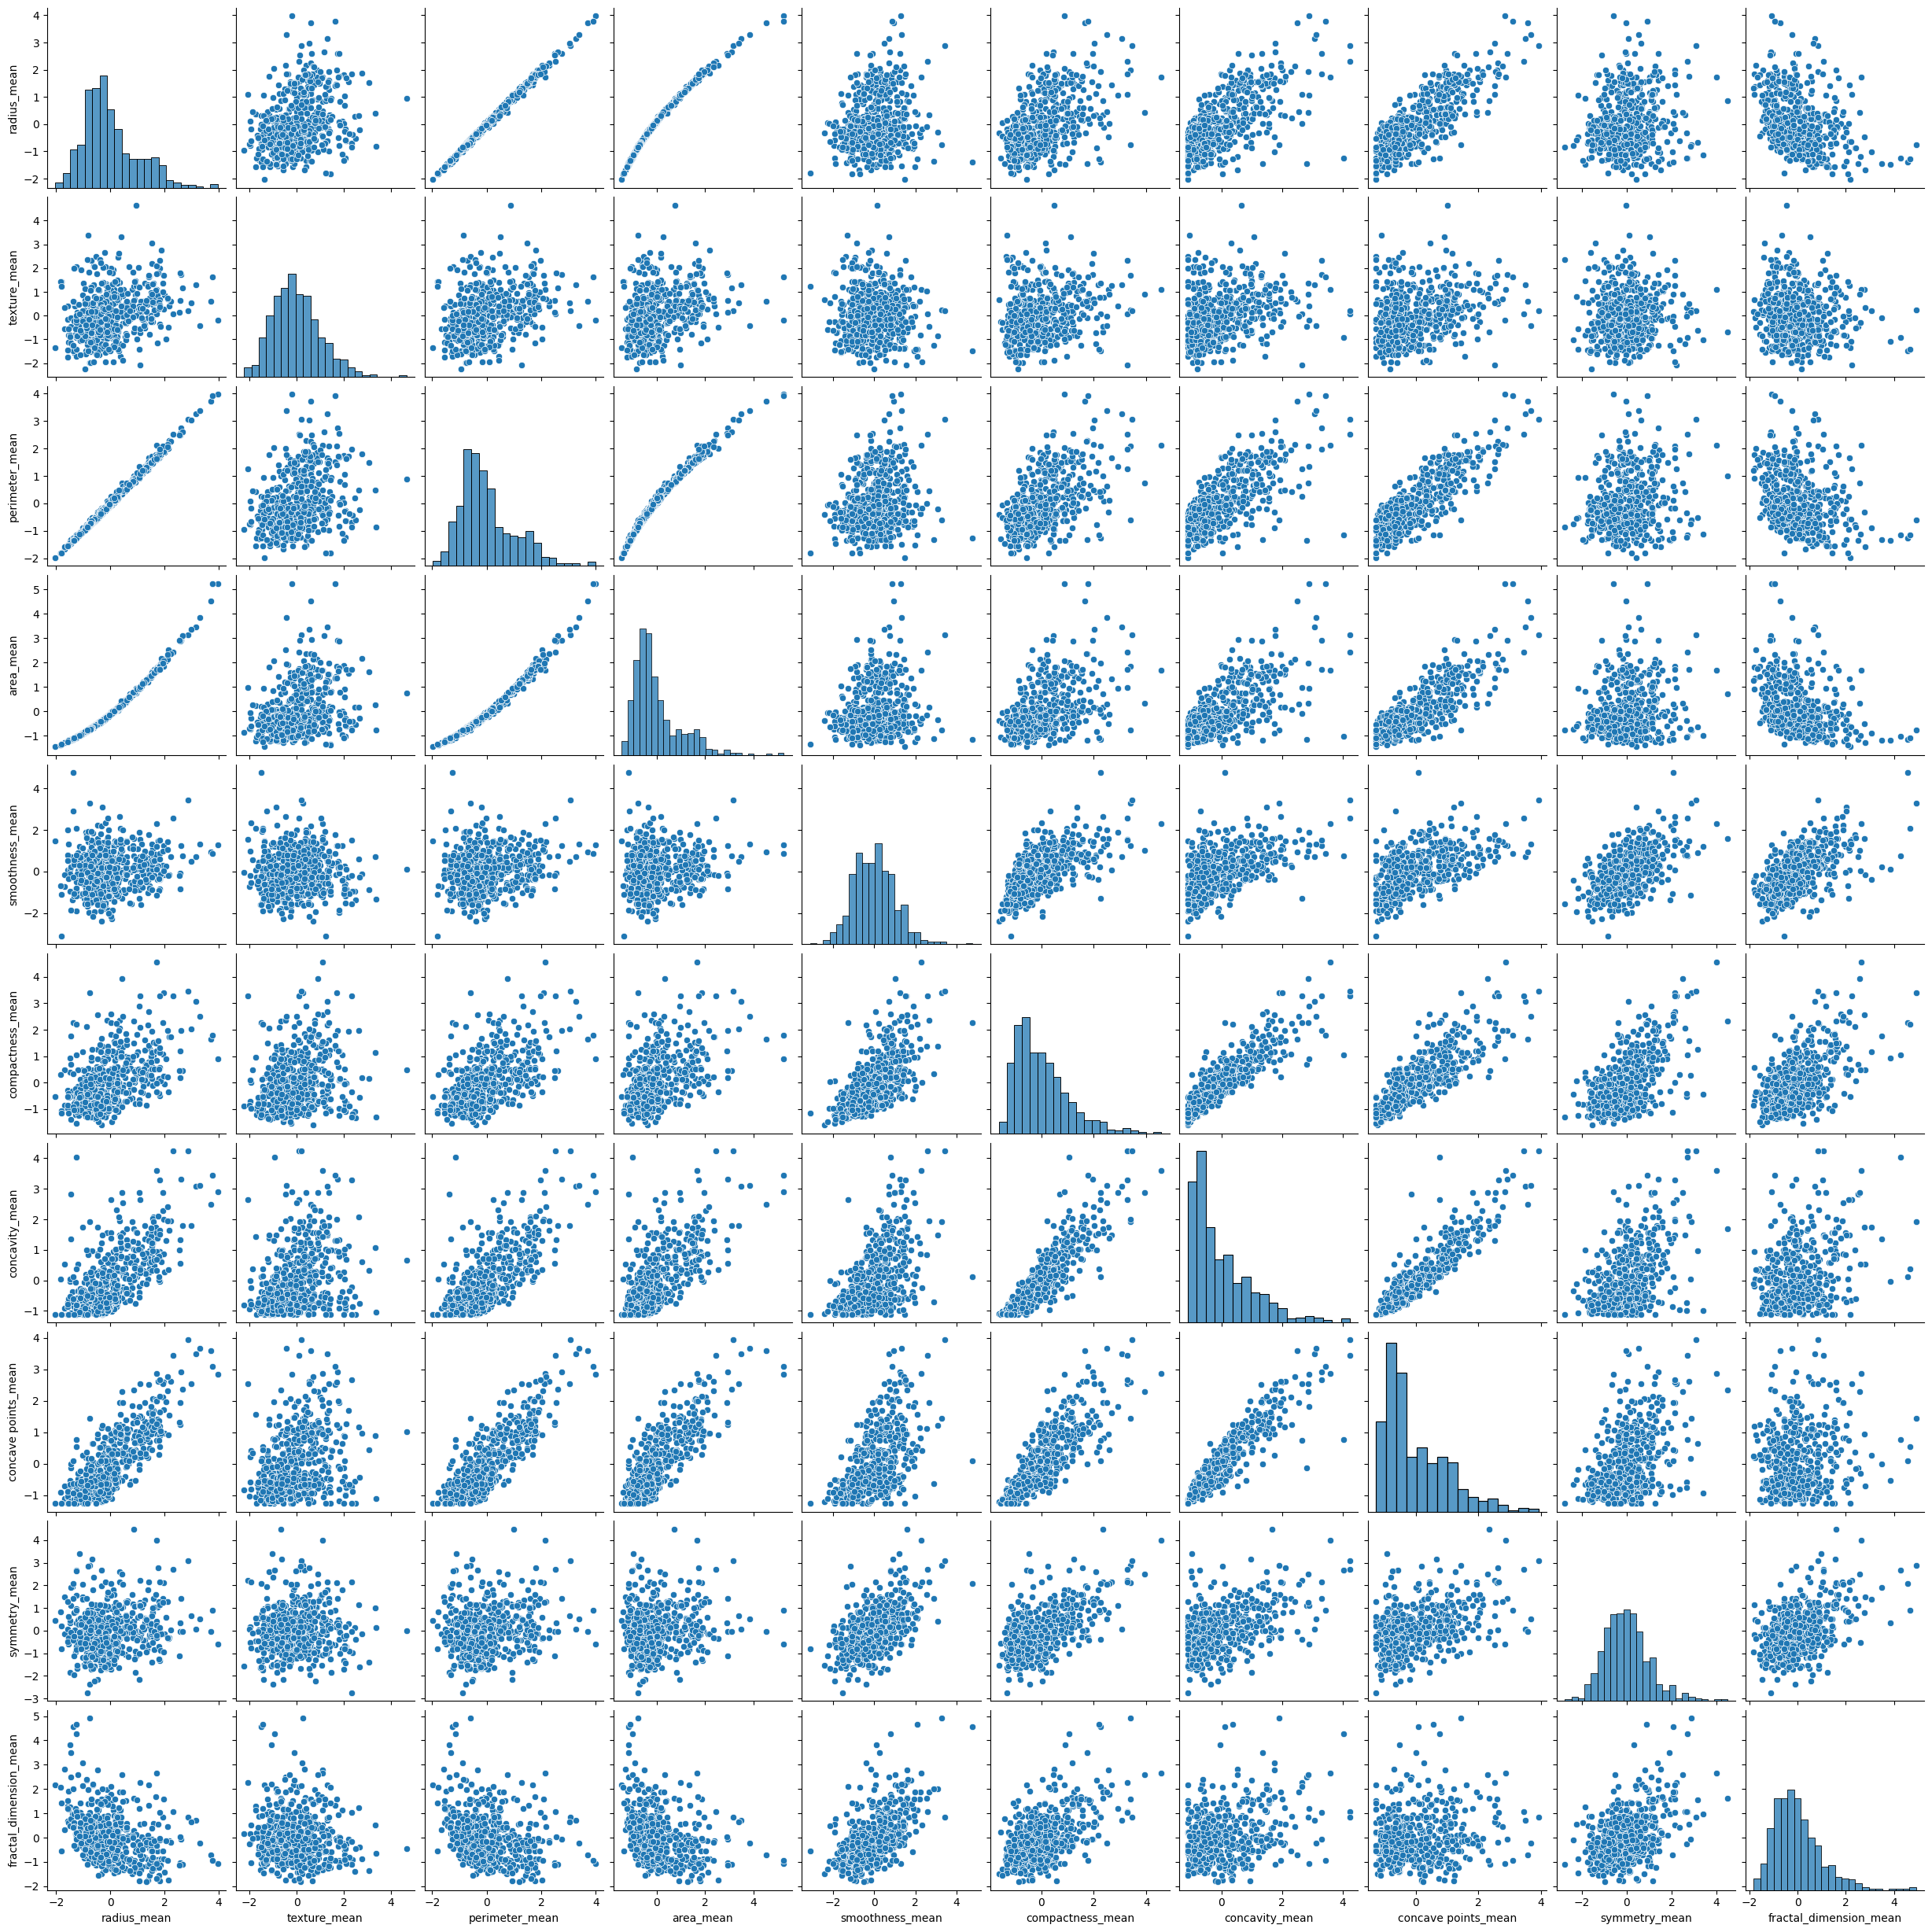

In [12]:
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Pair plot of all columns
sns.pairplot(df_scaled[mean_columns])
plt.show()

I also plotted histograms for each field, and I can see all of the measurement columns follow a normal distribution or logarithmic distribution. Knowing every value is populated will offer reliability in the training models. Most evidently, there are no outliers visible in this data.

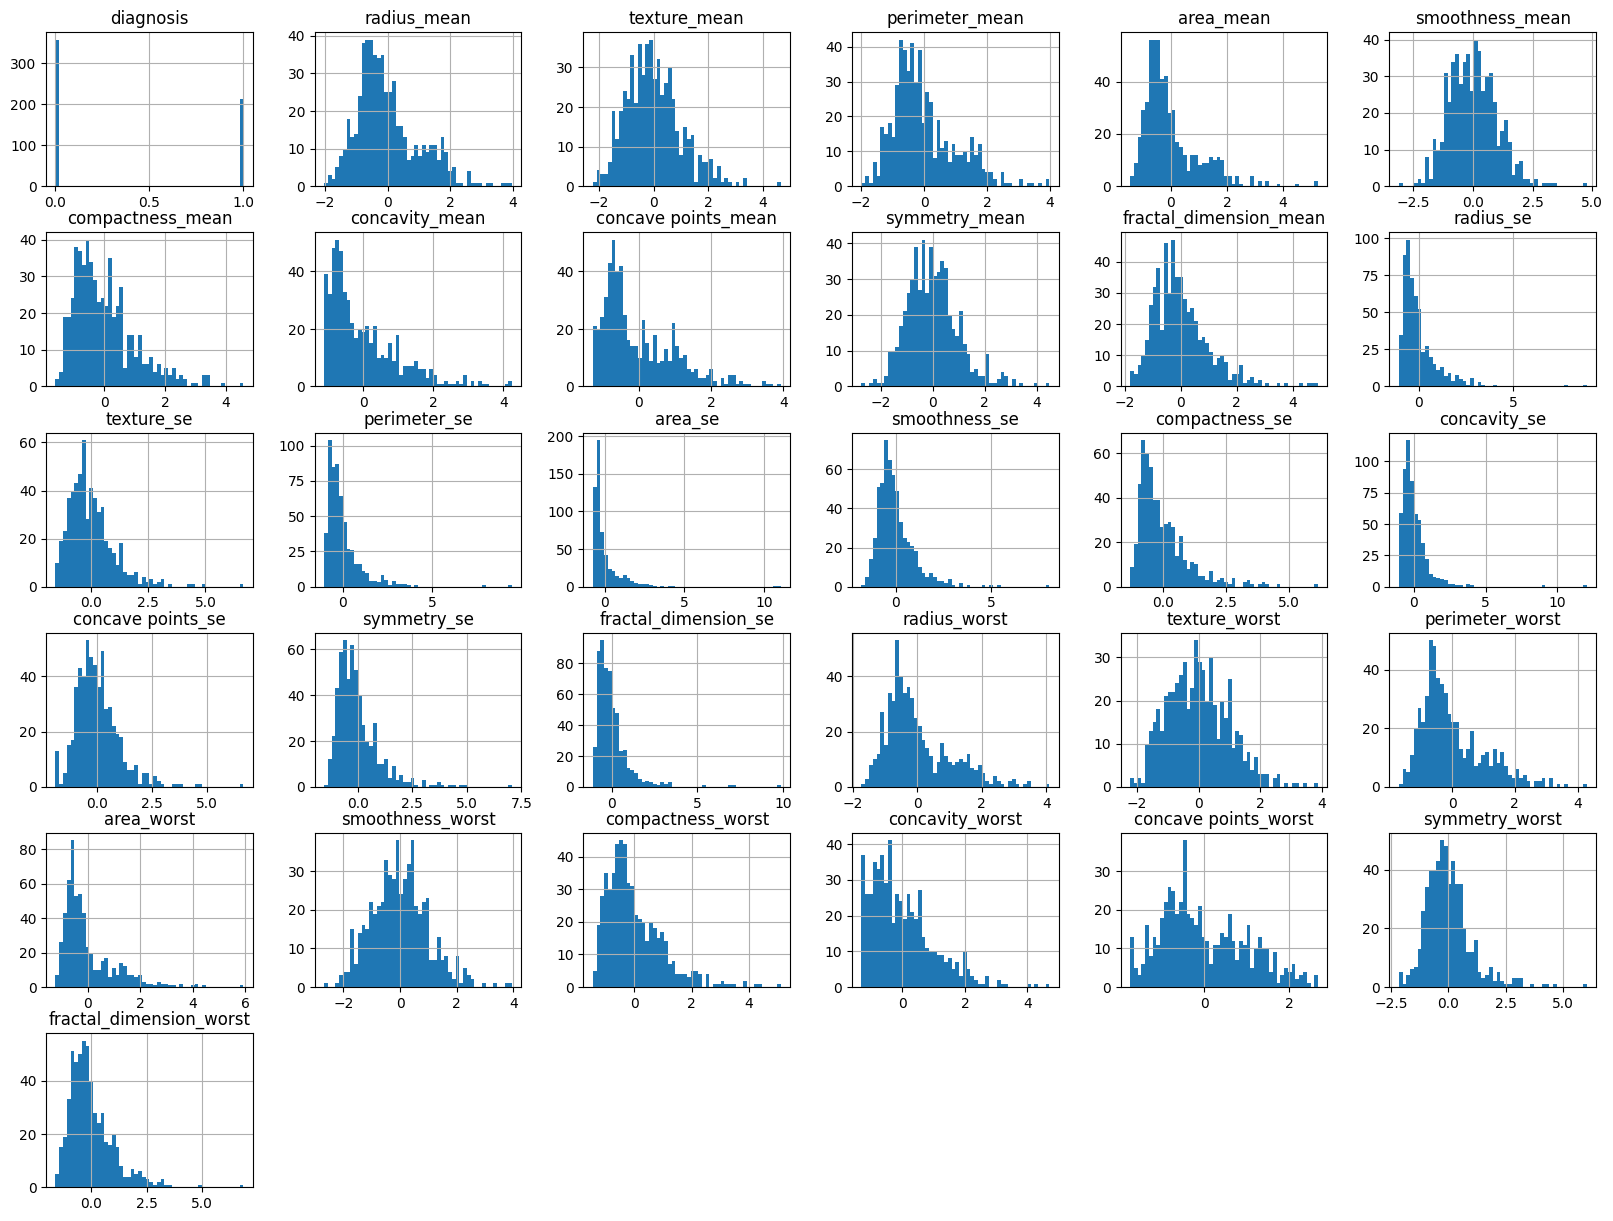

In [13]:
df_scaled.hist(bins=50, figsize=(20,15))
plt.show()

# Part 3: Model Training

## Model 1: KNN

For my KNN model, the business objective is to capture our false positive rate and to see if we can improve it with Linear Discriminant Analysis (LDA). Because we have strong clustering evident in the scatterplots, KNN is an intuitive choice as my first model to train. To test multiple k values, I used the K-folds technique.

For fold 1 where k = 1, the accuracy is 0.9592
For fold 2 where k = 2, the accuracy is 0.9592
For fold 3 where k = 3, the accuracy is 0.9388
For fold 4 where k = 4, the accuracy is 0.8980
For fold 5 where k = 8, the accuracy is 0.9375
For fold 6 where k = 10, the accuracy is 0.9792
For fold 7 where k = 12, the accuracy is 0.9792
For fold 8 where k = 15, the accuracy is 0.9167
For fold 9 where k = 20, the accuracy is 0.9792
For fold 10 where k = 50, the accuracy is 0.9792


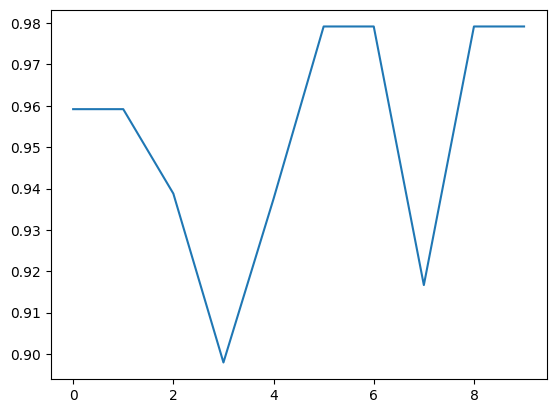

In [14]:
from sklearn.neighbors import KNeighborsClassifier

kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_choices = [1,2,3,4,8,10,12,15,20,50]
accuracies = []

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):

    # training sets
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    # validation sets
    x_val_fold =  x_train[val_index]
    y_val_fold = y_train[val_index]

    knn = KNeighborsClassifier(n_neighbors=k_choices[idx]) # choose a k_choice based on the value of idx
    knn.fit(x_train_fold, y_train_fold)
    y_prediction = knn.predict(x_val_fold)
    
    num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
    accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
    accuracies.append(accuracy) # append our results
    print(f"For fold {idx+1} where k = {k_choices[idx]}, the accuracy is {accuracy:.4f}")
    
plt.plot(accuracies)
plt.show()

My results yielded accuracy results consistently >.90, but the best ones were k=10, 12, 20, and 50 at 97.92%. Normally this is a good score, but let's see if I can bring that up to 99% with dimensionality reduction. 

#### KNN Model - After LDA
Since KNN is a supervised training model, hopefully LDA can improve the classification results through its ability to emphasize clustering.

In the next cell, I fit LDA on the training data. x_train

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1) # chose 1 component since there are only 2 classes
x_train_lda = lda.fit_transform(x_train,y_train)

Next, I use kfolds to measure the best accuracies across varying k choices on our data transformed by LDA.

For fold 1 where k = 1, the accuracy is 1.0000
For fold 2 where k = 2, the accuracy is 0.9592
For fold 3 where k = 3, the accuracy is 0.9388
For fold 4 where k = 4, the accuracy is 0.9388
For fold 5 where k = 8, the accuracy is 0.9583
For fold 6 where k = 10, the accuracy is 0.9792
For fold 7 where k = 12, the accuracy is 1.0000
For fold 8 where k = 15, the accuracy is 0.9792
For fold 9 where k = 20, the accuracy is 1.0000
For fold 10 where k = 50, the accuracy is 0.9792


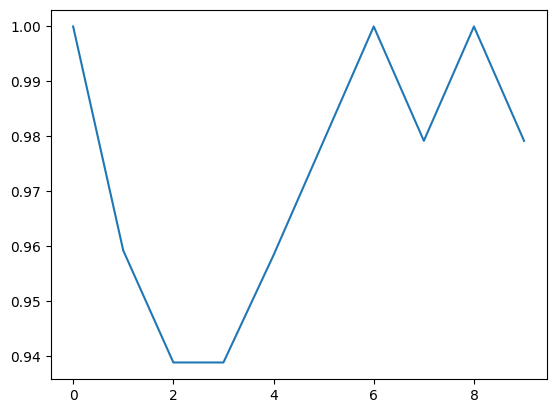

In [19]:
from sklearn.neighbors import KNeighborsClassifier

kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_choices = [1,2,3,4,8,10,12,15,20,50]
accuracies = []

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train_lda, y_train)):

    # training sets
    x_train_fold = x_train_lda[train_index]
    y_train_fold = y_train[train_index]
    
    # validation sets
    x_val_fold =  x_train_lda[val_index]
    y_val_fold = y_train[val_index]

    knn = KNeighborsClassifier(n_neighbors=k_choices[idx]) # choose a k_choice based on the value of idx
    knn.fit(x_train_fold, y_train_fold)
    y_prediction = knn.predict(x_val_fold)
    
    num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
    accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
    accuracies.append(accuracy) # append our results
    print(f"For fold {idx+1} where k = {k_choices[idx]}, the accuracy is {accuracy:.4f}")
    
plt.plot(accuracies)
plt.show()

Our results show 1, 12, and 20 as 100%. These are likely overfitted models, so I will avoid these. However, k=10 has 97.92% in both the non-LDA and LDA models and is the highest accuracy recorded outside of the overfitted models. I will move forward with k=10.

Below I will calculate the accuracy, confusion matrix, and ROC curve results on one fold without using LDA data to avoid overfitting.

For fold 6 where k = 10, the accuracy is 0.9792
Confusion matrix (cm): 
 [[30  0]
 [ 1 17]]


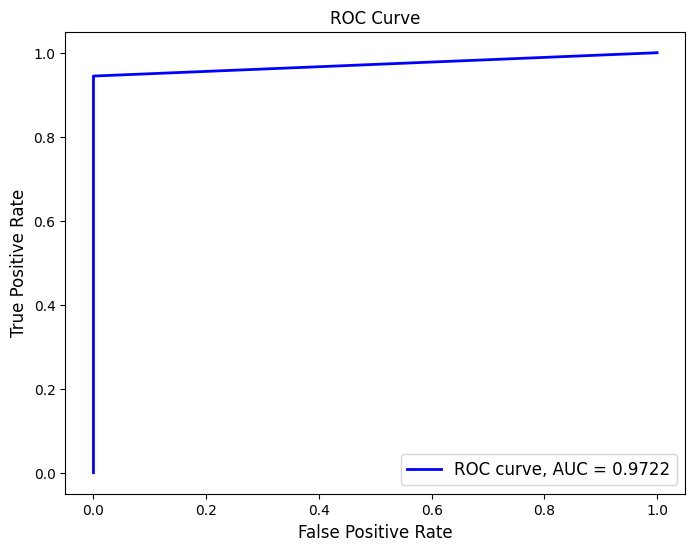

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
k_choices = [1,2,3,4,8,10,12,15,20,50]
accuracies = []

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train_lda, y_train)):

    if idx == 5:
        # training sets
        x_train_fold = x_train_lda[train_index]
        y_train_fold = y_train[train_index]
        
        # validation sets
        x_val_fold =  x_train_lda[val_index]
        y_val_fold = y_train[val_index]
    
        knn = KNeighborsClassifier(n_neighbors=k_choices[idx]) # choose a k_choice based on the value of idx
        knn.fit(x_train_fold, y_train_fold)
        y_prediction = knn.predict(x_val_fold)
        
        num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
        accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
        accuracies.append(accuracy) # append our results
        print(f"For fold {idx+1} where k = {k_choices[idx]}, the accuracy is {accuracy:.4f}")
        
        # calculate accuracy
        num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
        accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
        
        # calculate confusion matrix
        cm = confusion_matrix(y_val_fold, y_prediction)
        print(f"Confusion matrix (cm): \n {cm}")
        
        # calculate the ROC curve
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_val_fold, y_prediction)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        # plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(false_pos_rate, true_pos_rate, color="blue", lw=2, label=f"ROC curve, AUC = {roc_auc:.4f}")
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.title("ROC Curve", fontsize=12)
        plt.legend(loc="lower right", fontsize=12)
        plt.show()



Our results show the Area Under the Curve (AUC) is .9722.

#### KNN Model Results
From my results from one fold, I can see the non-LDA data has an accuracy of 97.92.% where k=10. The non-LDA model even has no false negatives. My ROC curve is favorable with an "Area Under the Curve" (AUC) > .9, proving that KNN is a good classifier.

However in healthcare, any misdiagnosed cases can be deadly. 97.92% accuracy is good, but let's see if I can improve the accuracy in the following models.

## Model 2: K Means

The business objective here is to successfully cluster my data and prove the binary classifications can be separated by their features. Given the data has 30 features, I will use Principal Component Analysis (PCA) to shape the data into 2D. I can then use that plane to visualize the data and the feature separation. Afterwards, I would like to use KMeans to see how well the model clusters when using PCA data. Below is our clustering when using PCA on the data.

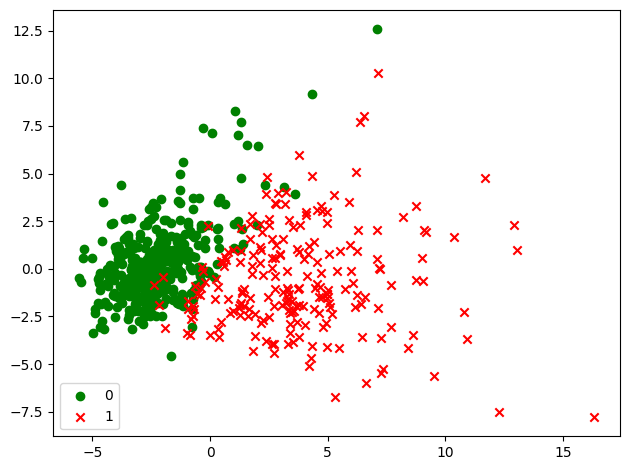

In [27]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# plot the training data after Principal Component Analysis
colors = ['g', 'r']
markers = ['o', 'x']
for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(x_pca[y == l, 0], 
                x_pca[y == l, 1], 
                c=c, label=l, marker=m)

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

From my plot we can see the Benign cases (green circles) are more densely clustered and generally have an value < 5. Malignant cases (red x) are not as densely clustered, and also exhibit more variance. There is still a lot of overlap between the two classifiers however.

Having done PCA on our data, lets see if KMeans is able to properly cluster the data. Since I have a binary classifier, I know the number of my clusters will be 2. n_clusters=2

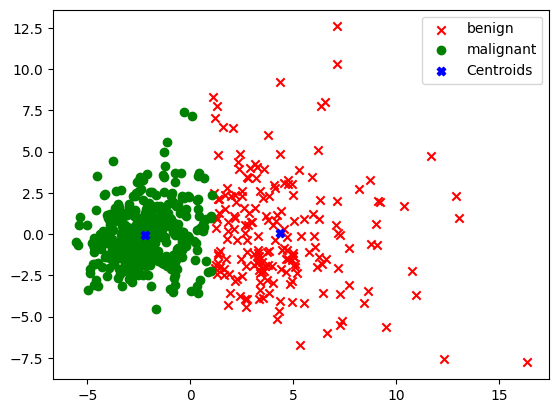

In [28]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

km.fit(x_pca)

labels = km.labels_ # cluster assignments
centroids = km.cluster_centers_ # cluster centroids

plt.scatter(x_pca[labels==0, 0], x_pca[labels==0, 1],
            c='red', marker='x', label='benign')

plt.scatter(x_pca[labels==1, 0], x_pca[labels==1, 1],
            c='green', marker='o', label='malignant')

plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', marker='X', label='Centroids') # plot centroids
plt.legend()
plt.show()

#### KMeans Model Results

In the plot above, I can see that the clustering after using K Means seems pretty well defined. The blue x’s are centroids, and one can see a clear boundary line between the two clusters. This indicates to me the feature space can be separated for malignant vs benign cases.

## Model 3: Support Vector Machines

Having seen our features can be clustered definitively in our PCA -> KMeans model, let's use Support Vector Machine to see if we can draw a boundary between the two classes. The objective here will be to train the best model we can knowing we have good clustering. I will use the Linear SVC model on the same PCA data from our KMeans model, since we know it shows better clustering. Again I will use the K folds technique, but for only 6 folds this time. The hyperparameter I will be testing is C, and I will be testing different multiples of ten.

In [30]:
from sklearn.svm import LinearSVC

kfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
C = [.001, .01, .1, 1, 10, 100]
accuracies = []

# split the x_pca data into training and test sets
x_train_pca, x_test_pca, y_train, y_test = train_test_split(x_pca,
                                                    y,
                                                    test_size=85,
                                                    stratify=y,
                                                    random_state=42)

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train_pca, y_train)):

    # training sets
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    # validation sets
    x_val_fold =  x_train[val_index]
    y_val_fold = y_train[val_index]

    svm = LinearSVC(C=C[idx]) # choose a k_choice based on the value of idx
    svm.fit(x_train_fold, y_train_fold)
    y_prediction = svm.predict(x_val_fold)
    
    num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
    accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
    accuracies.append(accuracy) # append our results
    print(f"For fold {idx+1} where C = {C[idx]}, the accuracy is {accuracy:.4f}")


For fold 1 where C = 0.001, the accuracy is 0.9630
For fold 2 where C = 0.01, the accuracy is 0.9259
For fold 3 where C = 0.1, the accuracy is 0.9753
For fold 4 where C = 1, the accuracy is 0.9630
For fold 5 where C = 10, the accuracy is 0.9875
For fold 6 where C = 100, the accuracy is 1.0000


I can see from my accuracy results in the k folds that 10 may have the best fit. C=100 is likely overfitted at 100%. Using C=10 on one fold, I will plot the confusion matrix and calculate the ROC.

For fold 5 where C = 10, the accuracy is 0.9875
Confusion matrix (cm): 
 [[49  1]
 [ 0 30]]


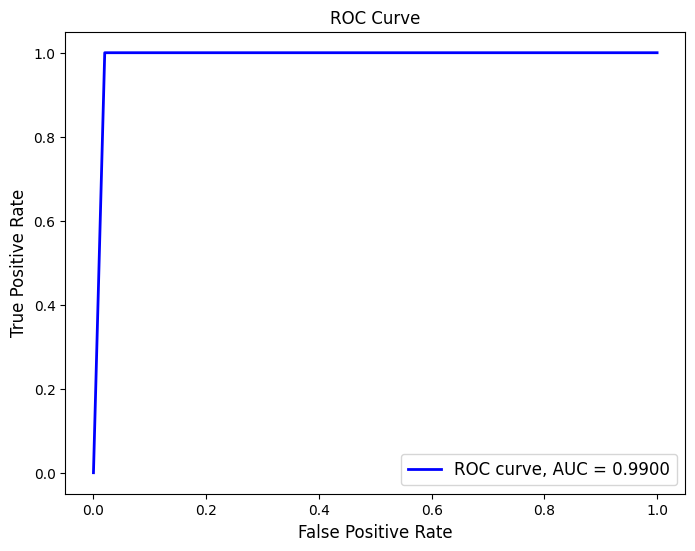

In [34]:
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train_pca, y_train)):

    if idx == 4:
        # training sets
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        
        # validation sets
        x_val_fold =  x_train[val_index]
        y_val_fold = y_train[val_index]
    
        svm = LinearSVC(C=C[idx]) # choose a k_choice based on the value of idx
        svm.fit(x_train_fold, y_train_fold)
        y_prediction = svm.predict(x_val_fold)
        
        num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
        accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
        accuracies.append(accuracy) # append our results
        print(f"For fold {idx+1} where C = {C[idx]}, the accuracy is {accuracy:.4f}")

        # confusion matrix
        cm = confusion_matrix(y_val_fold, y_prediction)
        print(f"Confusion matrix (cm): \n {cm}")
        
        # Calculating and plotting the ROC curve
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_val_fold, y_prediction)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(false_pos_rate, true_pos_rate, color="blue", lw=2, label=f"ROC curve, AUC = {roc_auc:.4f}")
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.title("ROC Curve", fontsize=12)
        plt.legend(loc="lower right", fontsize=12)


#### SVM Model Results

I can see above that the ROC curve is with an AUC=.9900. The model also has a 98.75% accuracy and no false negatives. A slightly better model compared to our KNN model at 97.92% accuracy. These measurements indicate that SVM is a better classifier than KNN.

# Part 4: Further Model Training

Next, I will expand on my Support Vector Machine (SVM) model and boost it with a K Means model. To begin, I only tested the C hyperparameter for my SVM model after the data was dimensionally reduced with Principal Component Analysis (PCA). I would like to see how well it performs using the additional "penalty" hyperparameter. 

I will use the data that has been dimensionally reduced by PCA, "x_train_pca", and compare the accuracies with different "C" and "penalty" values. The hyperparameters will be tested with K folds.

In [89]:
# This time I will use 12 folds, because there are 12 combinations between my C and penalty values.
kfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
C = [.001, .01, .1, 1, 10, 100]
penalties = ['l1','l2']
accuracies = []

#for train_index, val_index in kfolds.split(x_train, y_train):
for idx, (train_index, val_index) in enumerate(kfolds.split(x_train_pca, y_train)):

    # training sets
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    # validation sets
    x_val_fold =  x_train[val_index]
    y_val_fold = y_train[val_index]

    for penalty in penalties:

        svm = LinearSVC(C=C[idx], penalty=penalty) # choose a k_choice based on the value of idx
        svm.fit(x_train_fold, y_train_fold)
        y_prediction = svm.predict(x_val_fold)
        
        num_correct = np.sum(y_prediction == y_val_fold) # number of matches found
        accuracy = float(num_correct) / len(y_val_fold) # calculate the accuracy
        accuracies.append(accuracy) # append our results
        print(f"For fold {idx+1} where C = {C[idx]} and penalty = {penalty}, the accuracy is {accuracy:.4f}")


For fold 1 where C = 0.001 and penalty = l1, the accuracy is 0.6296
For fold 1 where C = 0.001 and penalty = l2, the accuracy is 0.9630
For fold 2 where C = 0.01 and penalty = l1, the accuracy is 0.9136
For fold 2 where C = 0.01 and penalty = l2, the accuracy is 0.9259
For fold 3 where C = 0.1 and penalty = l1, the accuracy is 0.9506
For fold 3 where C = 0.1 and penalty = l2, the accuracy is 0.9753
For fold 4 where C = 1 and penalty = l1, the accuracy is 0.9630
For fold 4 where C = 1 and penalty = l2, the accuracy is 0.9630
For fold 5 where C = 10 and penalty = l1, the accuracy is 0.9875
For fold 5 where C = 10 and penalty = l2, the accuracy is 0.9875
For fold 6 where C = 100 and penalty = l1, the accuracy is 1.0000
For fold 6 where C = 100 and penalty = l2, the accuracy is 1.0000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


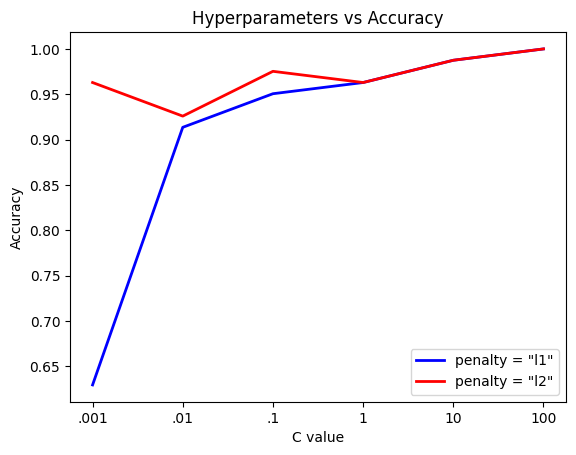

In [90]:
# Data for the lines
# x = [.001, .01, .1, 1, 10, 100] # C values
x = [".001",".01",".1","1","10","100"]
y1 = [accuracies[0], accuracies[2], accuracies[4], accuracies[6], accuracies[8], accuracies[10]] # l1 accuracies from the cell before this one
y2 = [accuracies[1], accuracies[3], accuracies[5], accuracies[7], accuracies[9], accuracies[11]] # l2 accuracies from the cell before this one

# Create the plot
plt.plot(x, y1, label='penalty = "l1"', color='blue', linestyle='-', linewidth=2)  # First line
plt.plot(x, y2, label='penalty = "l2"', color='red', linestyle='-', linewidth=2)   # Second line

# Add labels and title
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Hyperparameters vs Accuracy')

plt.legend()
plt.show()

From my plot, I can see the accuracies generally performed better when penalty = "l2" over 6 different C values, so I will use "l2" for penalty. For C, I can see C=100 is 100% which means it's likely overfitted. Rather, I will use C=10 where both "l1" and "l2" showed 98.75% accuracy.

Next, I will boost the SVC model with results from my K Means model. In my KMeans model, I will measure the distance to the centroids for each point, and add it as a feature to my dataset before using SVM. This can hopefully improve my results.

In [134]:
# km object is from KMeans model
cluster_distances = km.transform(x_pca) # distances to each cluster centroid

x_pca_boosted = np.hstack((x_pca, cluster_distances)) # add distances as new features to the data

# Split the x_pca_boosted into training and test sets
x_pca_boosted_train, x_pca_boosted_test, y_train, y_test = train_test_split(x_pca_boosted,
                                                    y,
                                                    test_size=85,
                                                    stratify=y,
                                                    random_state=42)

print(f"training data size before boosting: {x_pca.shape}")
print(f"training data size before boosting: {x_pca_boosted.shape}")

training data size before boosting: (569, 2)
training data size before boosting: (569, 4)


My data shape before boosting was 569 rows and two columns. After boosting it with results from my K Means model, it came out to 569 rows and four columns. With my new training data boosted, I fit the SVC model using penalty="l2" and C=10. I will then perform a prediction on the test data.

In [136]:
# fitting the SVC model with C=10 and penalty="l2"
svm = LinearSVC(C=10, penalty="l2")
svm.fit(x_pca_boosted_train, y_train)

y_svm_boosted_prediction = svm.predict(x_pca_boosted_test) # prediction on the test data

num_correct = np.sum(y_svm_boosted_prediction == y_test) # number of matches found
accuracy = float(num_correct) / len(y_test) # calculate the accuracy
accuracies.append(accuracy) # append our results
print(f"After PCA, and boosting from the K Means model, the SVM model with hyperparameters C = 10 and penalty = 'l2' yielded an accuracy of {accuracy:.4f}")

After PCA, and boosting from the K Means model, the SVM model with hyperparameters C = 10 and penalty = 'l2' yielded an accuracy of 0.9882


Confusion matrix (cm): 
 [[53  0]
 [ 2 30]]


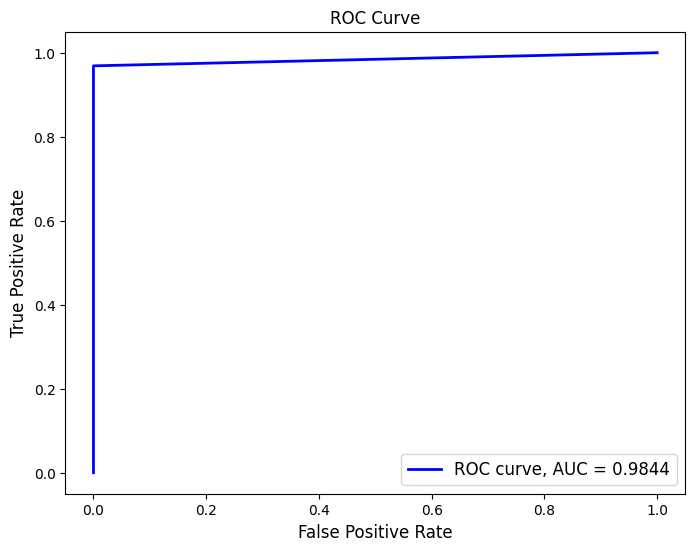

In [137]:
# confusion matrix
cm = confusion_matrix(y_test, y_svm_prediction)
print(f"Confusion matrix (cm): \n {cm}")

# Calculating and plotting the ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_svm_boosted_prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_pos_rate, true_pos_rate, color="blue", lw=2, label=f"ROC curve, AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

To further validate my results, I calculated the ROC and AUC. With an AUC of .9844, I know my model is reliable.

For future development, more data samples from a variety of sources would be helpful. The models yielded high accuracy, but the robustness against other data sets is yet to be determined. On a more technical note, this model could benefit from a bagging technique with three different models. Because only two of my models yielded binary classification results, I opted for a boosting technique instead. This proved successful with a 98.82 accuracy and no false negatives.